In [10]:
# Importing required libraries
import pandas as pd
import numpy as np

# Load the mortgage dataset
mortgage_data = pd.read_csv('Credit_Data.csv')

# Display the initial rows of the dataset for inspection
mortgage_data.head()


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [11]:
def mse_based_quantization(data, n_buckets):
    """
    Quantize the FICO scores into specified number of buckets and calculate the MSE.

    Parameters:
    - data (pd.DataFrame): The dataset containing FICO scores.
    - n_buckets (int): The number of buckets to create.

    Returns:
    - float: The calculated mean squared error for the quantization.
    - IntervalIndex: The bin intervals used for the quantization.
    """
    data['bucket'], bins = pd.qcut(data['fico_score'], q=n_buckets, labels=False, retbins=True, duplicates='drop')
    bucket_means = data.groupby('bucket')['fico_score'].mean().to_dict()
    data['mapped_score'] = data['bucket'].map(bucket_means)
    mse = ((data['fico_score'] - data['mapped_score']) ** 2).mean()
    return mse, bins

# Quantizing FICO scores using different bucket numbers and calculating MSE
mse_values = [mse_based_quantization(mortgage_data.copy(), n) for n in [5, 10, 15]]
mse_values


[(392.6494950978713, array([408., 587., 623., 653., 688., 850.])),
 (157.51584527078137,
  array([408., 560., 587., 607., 623., 638., 653., 670., 688., 714., 850.])),
 (90.17138250314792,
  array([408., 546., 571., 587., 600., 612., 623., 634., 643., 653., 664.,
         675., 688., 705., 727., 850.]))]

In [12]:
def log_likelihood_quantization(data, n_buckets):
    """
    Quantize the FICO scores and calculate the log likelihood based on defaults.

    Parameters:
    - data (pd.DataFrame): The dataset containing FICO scores and default information.
    - n_buckets (int): The number of buckets to create.

    Returns:
    - float: The calculated log likelihood for the quantization.
    - IntervalIndex: The bin intervals used for the quantization.
    """
    data['bucket'], bins = pd.qcut(data['fico_score'], q=n_buckets, labels=False, retbins=True, duplicates='drop')
    bucket_summary = data.groupby('bucket').agg(total_records=('fico_score', 'size'), defaults=('default', 'sum'))
    bucket_summary['pd'] = bucket_summary['defaults'] / bucket_summary['total_records']
    bucket_summary['log_likelihood'] = bucket_summary.apply(
        lambda row: row['defaults'] * np.log(row['pd']) + (row['total_records'] - row['defaults']) * np.log(1 - row['pd']),
        axis=1
    )
    total_log_likelihood = bucket_summary['log_likelihood'].sum()
    return total_log_likelihood, bins

# Quantizing FICO scores using different bucket numbers and calculating log likelihood
log_likelihood_values = [log_likelihood_quantization(mortgage_data.copy(), n) for n in [5, 10, 15]]
log_likelihood_values



[(-4321.032467949177, array([408., 587., 623., 653., 688., 850.])),
 (-4267.901398927441,
  array([408., 560., 587., 607., 623., 638., 653., 670., 688., 714., 850.])),
 (-4252.149714701494,
  array([408., 546., 571., 587., 600., 612., 623., 634., 643., 653., 664.,
         675., 688., 705., 727., 850.]))]

Descriptive Statistics for FICO Scores:
count    10000.000000
mean       637.557700
std         60.657906
min        408.000000
25%        597.000000
50%        638.000000
75%        679.000000
max        850.000000
Name: fico_score, dtype: float64

-----------------------

Quantization Results:
   Number of Buckets         MSE  Log-Likelihood
0                  5  392.649495    -4321.032468
1                 10  157.515845    -4267.901399
2                 15   90.171383    -4252.149715

-----------------------



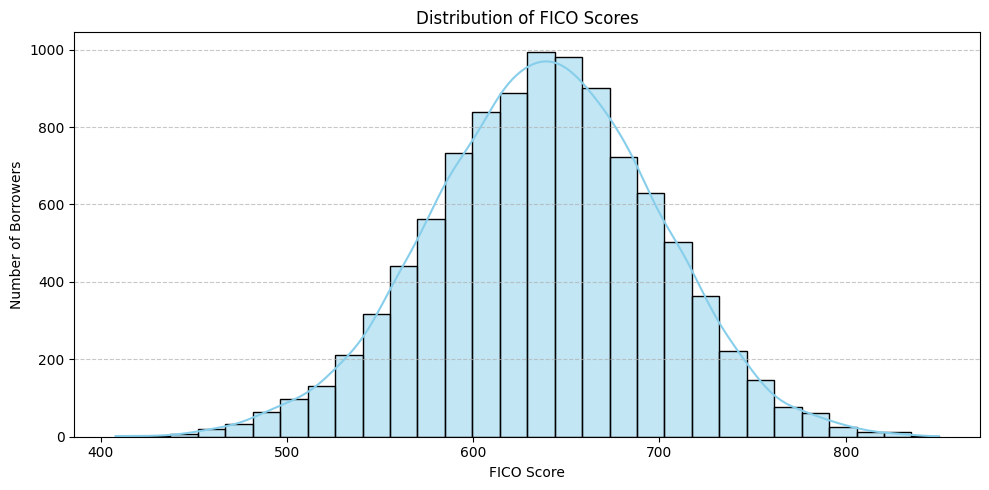

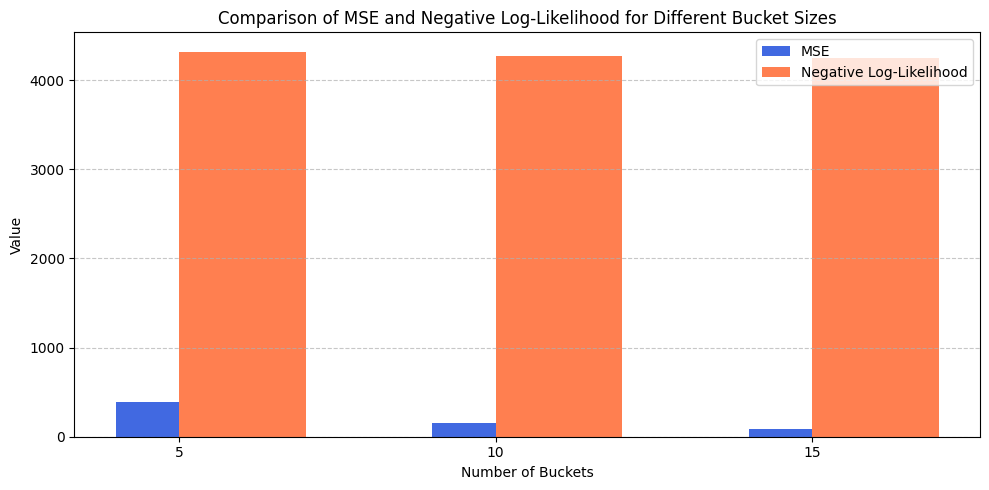


Summary:

Based on both MSE and Log-Likelihood quantizations, segmenting the FICO scores into 10 buckets appears to provide a 
suitable balance between accuracy and interpretability. This quantization approach offers insights into borrower risk 
categories, essential for credit risk modeling and decision-making.



In [13]:
# Required Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Descriptive Analysis
desc_stats = mortgage_data['fico_score'].describe()
print("Descriptive Statistics for FICO Scores:")
print(desc_stats)
print("\n-----------------------\n")

# Table Presentation for MSE and Log-Likelihood Results
bucket_sizes = [5, 10, 15]
mse_results = [res[0] for res in mse_values]
log_likelihood_results = [res[0] for res in log_likelihood_values]

results_df = pd.DataFrame({
    'Number of Buckets': bucket_sizes,
    'MSE': mse_results,
    'Log-Likelihood': log_likelihood_results
})

print("Quantization Results:")
print(results_df)
print("\n-----------------------\n")

# Visualization
# Distribution of FICO scores
plt.figure(figsize=(10, 5))
sns.histplot(mortgage_data['fico_score'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of FICO Scores")
plt.xlabel("FICO Score")
plt.ylabel("Number of Borrowers")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar chart for MSE and Log-Likelihood results
plt.figure(figsize=(10, 5))
x = range(len(bucket_sizes))
plt.bar(x, mse_results, width=0.4, label='MSE', color='royalblue', align='center')
plt.bar(x, [-val for val in log_likelihood_results], width=0.4, label='Negative Log-Likelihood', color='coral', align='edge')
plt.xticks(x, bucket_sizes)
plt.xlabel("Number of Buckets")
plt.ylabel("Value")
plt.title("Comparison of MSE and Negative Log-Likelihood for Different Bucket Sizes")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Summary
print("\nSummary:")
print("""
Based on both MSE and Log-Likelihood quantizations, segmenting the FICO scores into 10 buckets appears to provide a
suitable balance between accuracy and interpretability. This quantization approach offers insights into borrower risk
categories, essential for credit risk modeling and decision-making.
""")
